In [13]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
import time

# Set the path to the EdgeDriver executable
edge_service = Service("C:/Users/serap/Downloads/edgedriver_win64/msedgedriver.exe")
driver = webdriver.Edge(service=edge_service)

try:
    # Open the IMDb reviews page - "Uncharted"
    url = "https://www.imdb.com/title/tt1464335/reviews"
    driver.get(url)
    time.sleep(5)  # Allow the page to load

    # Load all reviews by clicking "Load More" until no more button is found
    try:
        while True:
            load_more_button = driver.find_element(By.CLASS_NAME, "load-more-data")
            load_more_button.click()
            time.sleep(2)  # Wait for the new reviews to load
    except:
        print("No more 'Load More' button found or an error occurred")

    # Extract review texts
    review_elements = driver.find_elements(By.CLASS_NAME, "ipc-html-content-inner-div")
    review_texts = [review.text for review in review_elements]

    # Print the first 5 reviews to verify
    for i, review in enumerate(review_texts[:5], start=1):
        print(f"Review {i}:\n{review}\n")

finally:
    # Close the browser
    driver.quit()


No more 'Load More' button found or an error occurred
Review 1:
Obvious cgi, plot holes, and lack of character depth made uncharted fall in the kind of lame category. Some funny moments between Wahlberg and Holland and decent sets. It was just too unbelievable.

Review 2:
I'm being really generous with 6 stars, because this movie is neither really funny, nor really exciting.

Not any good? The CGI effects are pretty special, but personally I often get bored when the CGI effects are the only thing keeping a movie afloat. And there are basically only 2 CGI spectacle scenes that are noteworthy and even those I found somewhat overkill and boring.

Let's forget about the story. This is merely another adventure movie, like the Pirates of the Carribean meets National Treasure. It'll do if there is nothing else to watch, but dont expect any originality, dont expect many laughs and dont expect much thrillling action either...

Review 3:
This Uncharted adaptation is decent at best. The video gam

#### Vectorizing the Reviews (TF-IDF)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the reviews to get their TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(review_texts)

# Print the shape of the resulting matrix
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")


TF-IDF Matrix Shape: (24, 1153)


### Clustering

In [17]:
from sklearn.cluster import KMeans

# Number of clusters
num_clusters = 3

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Get the cluster labels
labels = kmeans.labels_

# Print out the reviews and their corresponding cluster
for i, label in enumerate(labels):
    print(f"Review {i+1} (Cluster {label}):\n{review_texts[i]}\n")


Review 1 (Cluster 2):
Obvious cgi, plot holes, and lack of character depth made uncharted fall in the kind of lame category. Some funny moments between Wahlberg and Holland and decent sets. It was just too unbelievable.

Review 2 (Cluster 2):
I'm being really generous with 6 stars, because this movie is neither really funny, nor really exciting.

Not any good? The CGI effects are pretty special, but personally I often get bored when the CGI effects are the only thing keeping a movie afloat. And there are basically only 2 CGI spectacle scenes that are noteworthy and even those I found somewhat overkill and boring.

Let's forget about the story. This is merely another adventure movie, like the Pirates of the Carribean meets National Treasure. It'll do if there is nothing else to watch, but dont expect any originality, dont expect many laughs and dont expect much thrillling action either...

Review 3 (Cluster 1):
This Uncharted adaptation is decent at best. The video games are work of art

#### Visualize the Clusters in 2D

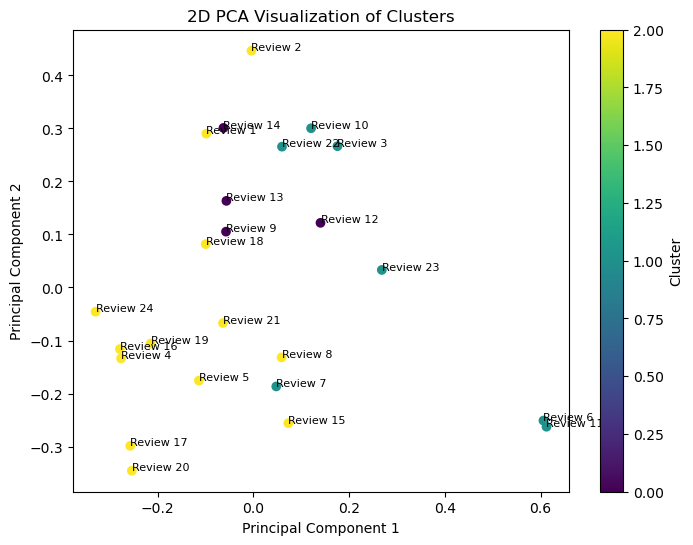

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Plot the 2D result
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')

# Add labels to the points
for i, txt in enumerate(labels):
    plt.annotate(f"Review {i+1}", (pca_result[i, 0], pca_result[i, 1]), fontsize=8)

plt.title("2D PCA Visualization of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()


#### Analysis

##### Cluster 0 (Negative Reviews): Focuses on the disappointment felt by long-time fans of the game. Criticism revolves around poor casting choices, lack of realism in the action, and weak character development. Many felt that the movie didn’t do justice to the original game franchise.

##### Cluster 1 (Neutral Reviews): These reviews are more balanced, acknowledging the fun action but pointing out flaws in the storytelling and character development. The movie is seen as entertaining, but not a perfect adaptation.


##### Cluster 2 (Positive Reviews): These reviews praise the movie as an enjoyable action-adventure film. The chemistry between the leads, fast-paced action, and overall entertainment value are highlights. Some flaws are mentioned, but they are seen as minor compared to the fun of the film.

In [26]:
print(cluster_counts)

Cluster
2    12
1     9
0     3
Name: count, dtype: int64


##### Since Cluster 2 contains the most reviews, positive reviews appear to be the most frequent in this case.

### TextBlob for Sentiment Analysis

In [28]:
from textblob import TextBlob

In [31]:
# Function to get sentiment polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to each review
sentiments = [get_sentiment(review) for review in review_texts]

# Convert sentiments into a DataFrame
sentiment_df = pd.DataFrame(sentiments, columns=['Polarity', 'Subjectivity'])

# Display the DataFrame with sentiment analysis
sentiment_df.head()  # Displaying the first few rows of the sentiment analysis


,Polarity,Subjectivity
0,0.044444,0.802778
1,0.053571,0.616964
2,-0.114103,0.543590
3,0.301045,0.470503
4,0.160174,0.552734


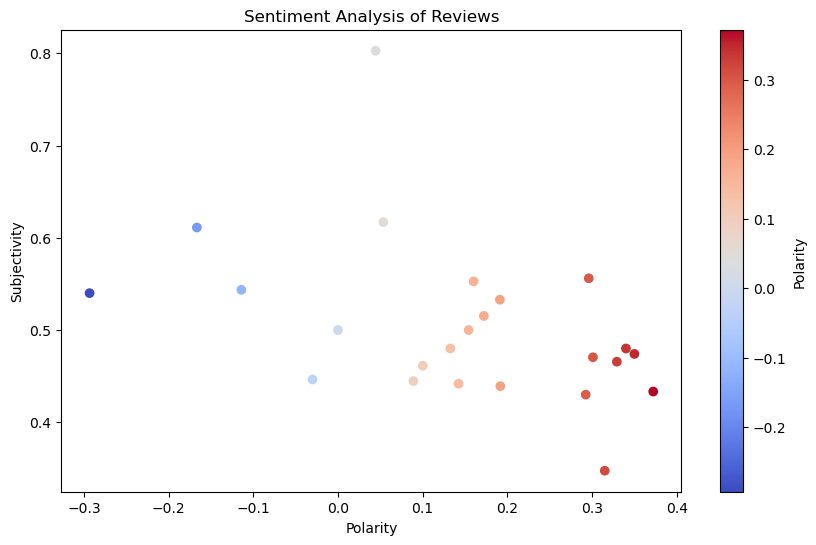

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(sentiment_df['Polarity'], sentiment_df['Subjectivity'], c=sentiment_df['Polarity'], cmap='coolwarm')
plt.title('Sentiment Analysis of Reviews')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.colorbar(label='Polarity')
plt.show()


In [33]:
# Categorize reviews based on polarity
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the categorization to each review
sentiment_df['Sentiment'] = sentiment_df['Polarity'].apply(categorize_sentiment)

# Display the first few rows with sentiment labels
sentiment_df.head()


,Polarity,Subjectivity,Sentiment
0,0.044444,0.802778,Positive
1,0.053571,0.616964,Positive
2,-0.114103,0.543590,Negative
3,0.301045,0.470503,Positive
4,0.160174,0.552734,Positive


In [34]:
# Count sentiment distribution
sentiment_distribution = sentiment_df['Sentiment'].value_counts()

# Display the sentiment distribution
print(sentiment_distribution)


Sentiment
Positive    19
Negative     4
Neutral      1
Name: count, dtype: int64


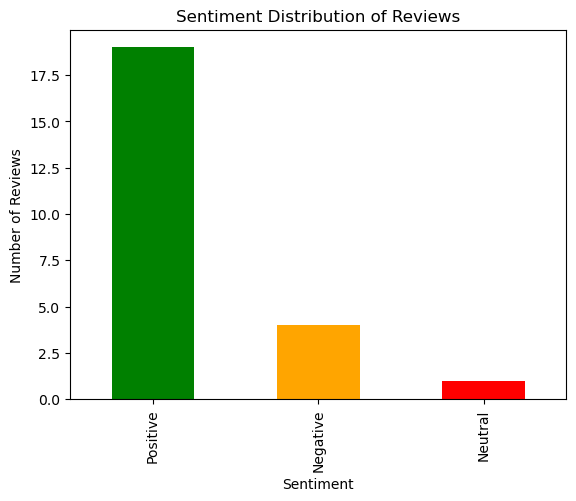

In [35]:
# Plot the distribution of sentiments
sentiment_distribution.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


##### Like in Cluster, in Sentiment Analysis, The majority of reviews (19 out of 24) are classified as positive, indicating that most reviewers had a favorable opinion of the movie.

##### The numbers seem different because Sentiment analysis is looking at the tone of each review individually, while clustering is grouping reviews based on shared features in the text.

##### The clusters don't strictly correspond to sentiment categories, but cluster groups can overlap with sentiment results. 